# AC FEUP 21/22

## Main dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
import sklearn

# use to not cut columns
pd.set_option('max_columns', None)

# njobs to use in sklearn models
configNJobs = -1

## Import data

### Training data

In [2]:
# import data
def read_csv(file, dtype={}, na_values=None):
    return pd.read_csv("data/" + file, sep=";", dtype=dtype, na_values=na_values)

account_df = read_csv("account.csv")
card_df = read_csv("card_train.csv")
client_df = read_csv("client.csv")
disp_df = read_csv("disp.csv")
district_df = read_csv("district.csv", na_values="?")
loan_df = read_csv("loan_train.csv")
trans_df = read_csv("trans_train.csv", dtype={'bank': 'str'})

trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


In [3]:
# clean column names (some columns come with an extra whitespace)
district_df.rename(columns=lambda x: x.strip(), inplace=True)

# rename some columns for easier interaction
district_df.rename(columns={"no. of inhabitants": "people_count",
                            "no. of municipalities with inhabitants < 499": "muni_499_count",
                            "no. of municipalities with inhabitants 500-1999": "muni_500-1999_count",
                            "no. of municipalities with inhabitants 2000-9999": "muni_2000-9999_count",
                            "no. of municipalities with inhabitants >10000": "muni_10000_count",
                            "no. of cities": "cities_count",
                            "ratio of urban inhabitants": "ratio_urban_people",
                            "average salary": "avg_salary",
                            "unemploymant rate '95": "unemp_rate_95",
                            "unemploymant rate '96": "unemp_rate_96",
                            "no. of enterpreneurs per 1000 inhabitants": "enterp_per1000",
                            "no. of commited crimes '95": "crime_count_95",
                            "no. of commited crimes '96": "crime_count_96"},
                   inplace=True)
district_df.head()

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159.0,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824.0,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244.0,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616.0,3040


### Test data

In [4]:
card_test_df = read_csv("card_test.csv")
loan_test_df = read_csv("loan_test.csv")
trans_test_df = read_csv("trans_test.csv", dtype={'bank': 'str'})

## Dealing with missing values

### Account data

In [5]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No NULL data to deal with on this dataframe.

### Card data

In [6]:
card_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

No NULL data to deal with on this dataframe.

In [7]:
card_test_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

### Client data

In [8]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

There are no NULL values on this dataset to deal with.

### Disposition data

In [9]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

No NULL data to deal with on this dataframe.

### District data

In [10]:
district_df.isnull().sum()

code                    0
name                    0
region                  0
people_count            0
muni_499_count          0
muni_500-1999_count     0
muni_2000-9999_count    0
muni_10000_count        0
cities_count            0
ratio_urban_people      0
avg_salary              0
unemp_rate_95           1
unemp_rate_96           0
enterp_per1000          0
crime_count_95          1
crime_count_96          0
dtype: int64

There is 1 NULL value in _unemploymant rate '95_ and _no. of commited crimes '95_.

In [11]:
district_df[district_df["unemp_rate_95"].isnull()]

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,NaN,7.01,124,NaN,1358


Both of these missing value are for the district of _Jesenik_. We can find the mean growth/shrinkage of the unemploymant and number of crimes commit from 1995 to 1996, and use that to fill the missing values of 1995 for this district.

In [12]:
unem_rate_95 = district_df[district_df["unemp_rate_95"].notnull()]["unemp_rate_95"]
unem_rate_96 = district_df[district_df["unemp_rate_96"].notnull()]["unemp_rate_96"]

unem_growth_series = unem_rate_95 / unem_rate_96
unem_growth = unem_growth_series.sum() / unem_growth_series.count()

district_df["unemp_rate_95"] = district_df.apply(lambda x: x["unemp_rate_96"] * unem_growth if np.isnan(x["unemp_rate_95"]) else x["unemp_rate_95"], axis=1)

In [13]:
no_crime_95 = district_df[district_df["crime_count_95"].notnull()]["crime_count_95"]
no_crime_96 = district_df[district_df["crime_count_96"].notnull()]["crime_count_96"]

crime_growth_series = no_crime_95 / no_crime_96
crime_growth = crime_growth_series.sum() / crime_growth_series.count()

district_df["crime_count_95"] = district_df.apply(lambda x: x["crime_count_96"] * crime_growth if np.isnan(x["crime_count_95"]) else x["crime_count_95"], axis=1)

In [14]:
district_df[district_df["code"] == 69]

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,5.759683,7.01,124,1321.520511,1358


The missing values have been taken care of.

### Loan data

In [15]:
loan_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

There are no NULL values to fill on this dataframe.

In [16]:
loan_test_df.isnull().sum()

loan_id         0
account_id      0
date            0
amount          0
duration        0
payments        0
status        354
dtype: int64

These missing values (_status_) don't matter as they are the targets of our prediction model.

### Transaction data

In [17]:
trans_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

In [18]:
trans_test_df.isnull().sum()

trans_id          0
account_id        0
date              0
type              0
operation      5130
amount            0
balance           0
k_symbol      17419
bank          24377
account       21061
dtype: int64

There are 4 attributes with a large quantity of null values on this dataframe that have to dealt with: _operation_, _k\_symbol_, _bank_, and _account_.

In [19]:
trans_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [20]:
len(trans_df[trans_df['operation'].isnull()]) / len(trans_df['operation']) * 100.0

17.838083113805663

The _operation_ attribute is categorical and doesn't reveal an inherited order. It can be enconded with 3 attributes using binary encoding.

This attribute is problematic because it contains a significant number of NULL values ($17.8\%$).

It was decided that these rows will be filled with _unkown_.

In [21]:
trans_df['operation'].fillna('unknown', inplace=True)

trans_test_df['operation'].fillna('unknown', inplace=True)

In [22]:
trans_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There is a category that is an empty string. It is likelly that the missing values were intended to be part of this category aswell. It is assumed that these rows with the _empty_ category refer to common transactions that aren't related to pensions, insurrance, etc... The missing values and the empty rows of this attribute will be renamed to _no_symbol_.

In [23]:
def treat_null_k_symbol(row):
    k_symb = row['k_symbol']
    if isinstance(k_symb, float):
        return 'no_symbol'
    elif k_symb == " ":
        return 'no_symbol'
    else:
        return k_symb
    

trans_df['k_symbol'] = trans_df.apply(treat_null_k_symbol, axis=1)
trans_test_df['k_symbol'] = trans_test_df.apply(treat_null_k_symbol, axis=1)

trans_df['k_symbol'].value_counts()

no_symbol                                204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

There many rows where we don't know which is the bank of the partner.

In [24]:
trans_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

In [25]:
trans_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

The unknown information about the partner's bank tranlates to unkown information about the partner. This is sometimes represented by a **0** on the _account_ attribute.

In [26]:
print("Number of unknown banks:", len(trans_df[trans_df['bank'].isnull()]))
print("Number of unknown partners:", len(trans_df[trans_df['account'].isnull()]) + len(trans_df[trans_df['account'] == 0]))

Number of unknown banks: 299443
Number of unknown partners: 299443


The number of unknown banks is the same as the number of unkown partners => these 2 features are highly correlated. Even though these 2 attributes aren't likelly to contribute anything to our dataset, we can create an **'unknown' bank** and set all unkown _account_ attributes to 0.

In [27]:
trans_df['account'].fillna(0, inplace=True)
trans_df['bank'].fillna("unknown", inplace=True)

trans_test_df['account'].fillna(0, inplace=True)
trans_test_df['bank'].fillna("unknown", inplace=True)

trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol,unknown,0.0
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol,unknown,0.0
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol,unknown,0.0
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol,unknown,0.0


## Feature selection

In [28]:
def parseYear(x):
    return x // 10000

def parseMonth(x):
    return x // 100 % 100

def parseDay(x):
    return x % 100

### Client

#### Work with client's birth_number

From this attribute we can extract the client's date of birth and gender.

In [29]:
def identify_gender(row):
    birth = row['birth_number']
    month = (birth // 100) % 100
    return False if month > 12 else True

# create a new gender column
client_df['is_male'] = client_df.apply(identify_gender, axis=1)

From the date of birth, we can derive the client's age.

In [30]:
def identify_year(row):
    birth = row['birth_number']
    year = birth // 10000
    return year

# create a new age column with client's age in year
# dataset is from 99
client_df['age'] = 99 - client_df.apply(identify_year, axis=1)

In [31]:
client_df.drop(['birth_number'], axis=1, inplace=True)

#### Discretize client ages

In [32]:
# discretize ages
age_bins=[0, 20, 29, 39, 49, 66, 150]
labels=['0-19', '20-29', '30-39', '40-49', '50-65', 'retired']
client_df['age'] = pd.cut(x=client_df['age'], bins=age_bins, labels=labels)

client_df['age']

0       20-29
1       50-65
2       50-65
3       40-49
4       30-39
        ...  
5364    50-65
5365    50-65
5366    30-39
5367    30-39
5368    40-49
Name: age, Length: 5369, dtype: category
Categories (6, object): ['0-19' < '20-29' < '30-39' < '40-49' < '50-65' < 'retired']

### Loan

#### Loan date

Separa the loan date into a month and year, so it can be explored later: maybe more loans are granted during winter or summer time.

In [33]:
# separate the loan date into loan year and loan month
def loan_ym(loan_df):
    loan_df['year_loan'] = loan_df['date'].apply(parseYear)
    loan_df['month_loan'] = loan_df['date'].apply(parseMonth)
    
loan_ym(loan_df)
loan_ym(loan_test_df)

### Transaction

#### Apply transaction types to the transaction amount

Withdrawls imply a negative balance change on the account's funds.

In [34]:
def convert_amount(row):
    ammount = abs(row['amount'])
    # else are withdrawls
    return ammount if row['type'] == "credit" else -ammount

# convert ammount to negative according to transaction type
trans_df['amount'] = trans_df.apply(convert_amount, axis=1)
trans_test_df['amount'] = trans_test_df.apply(convert_amount, axis=1)

### District

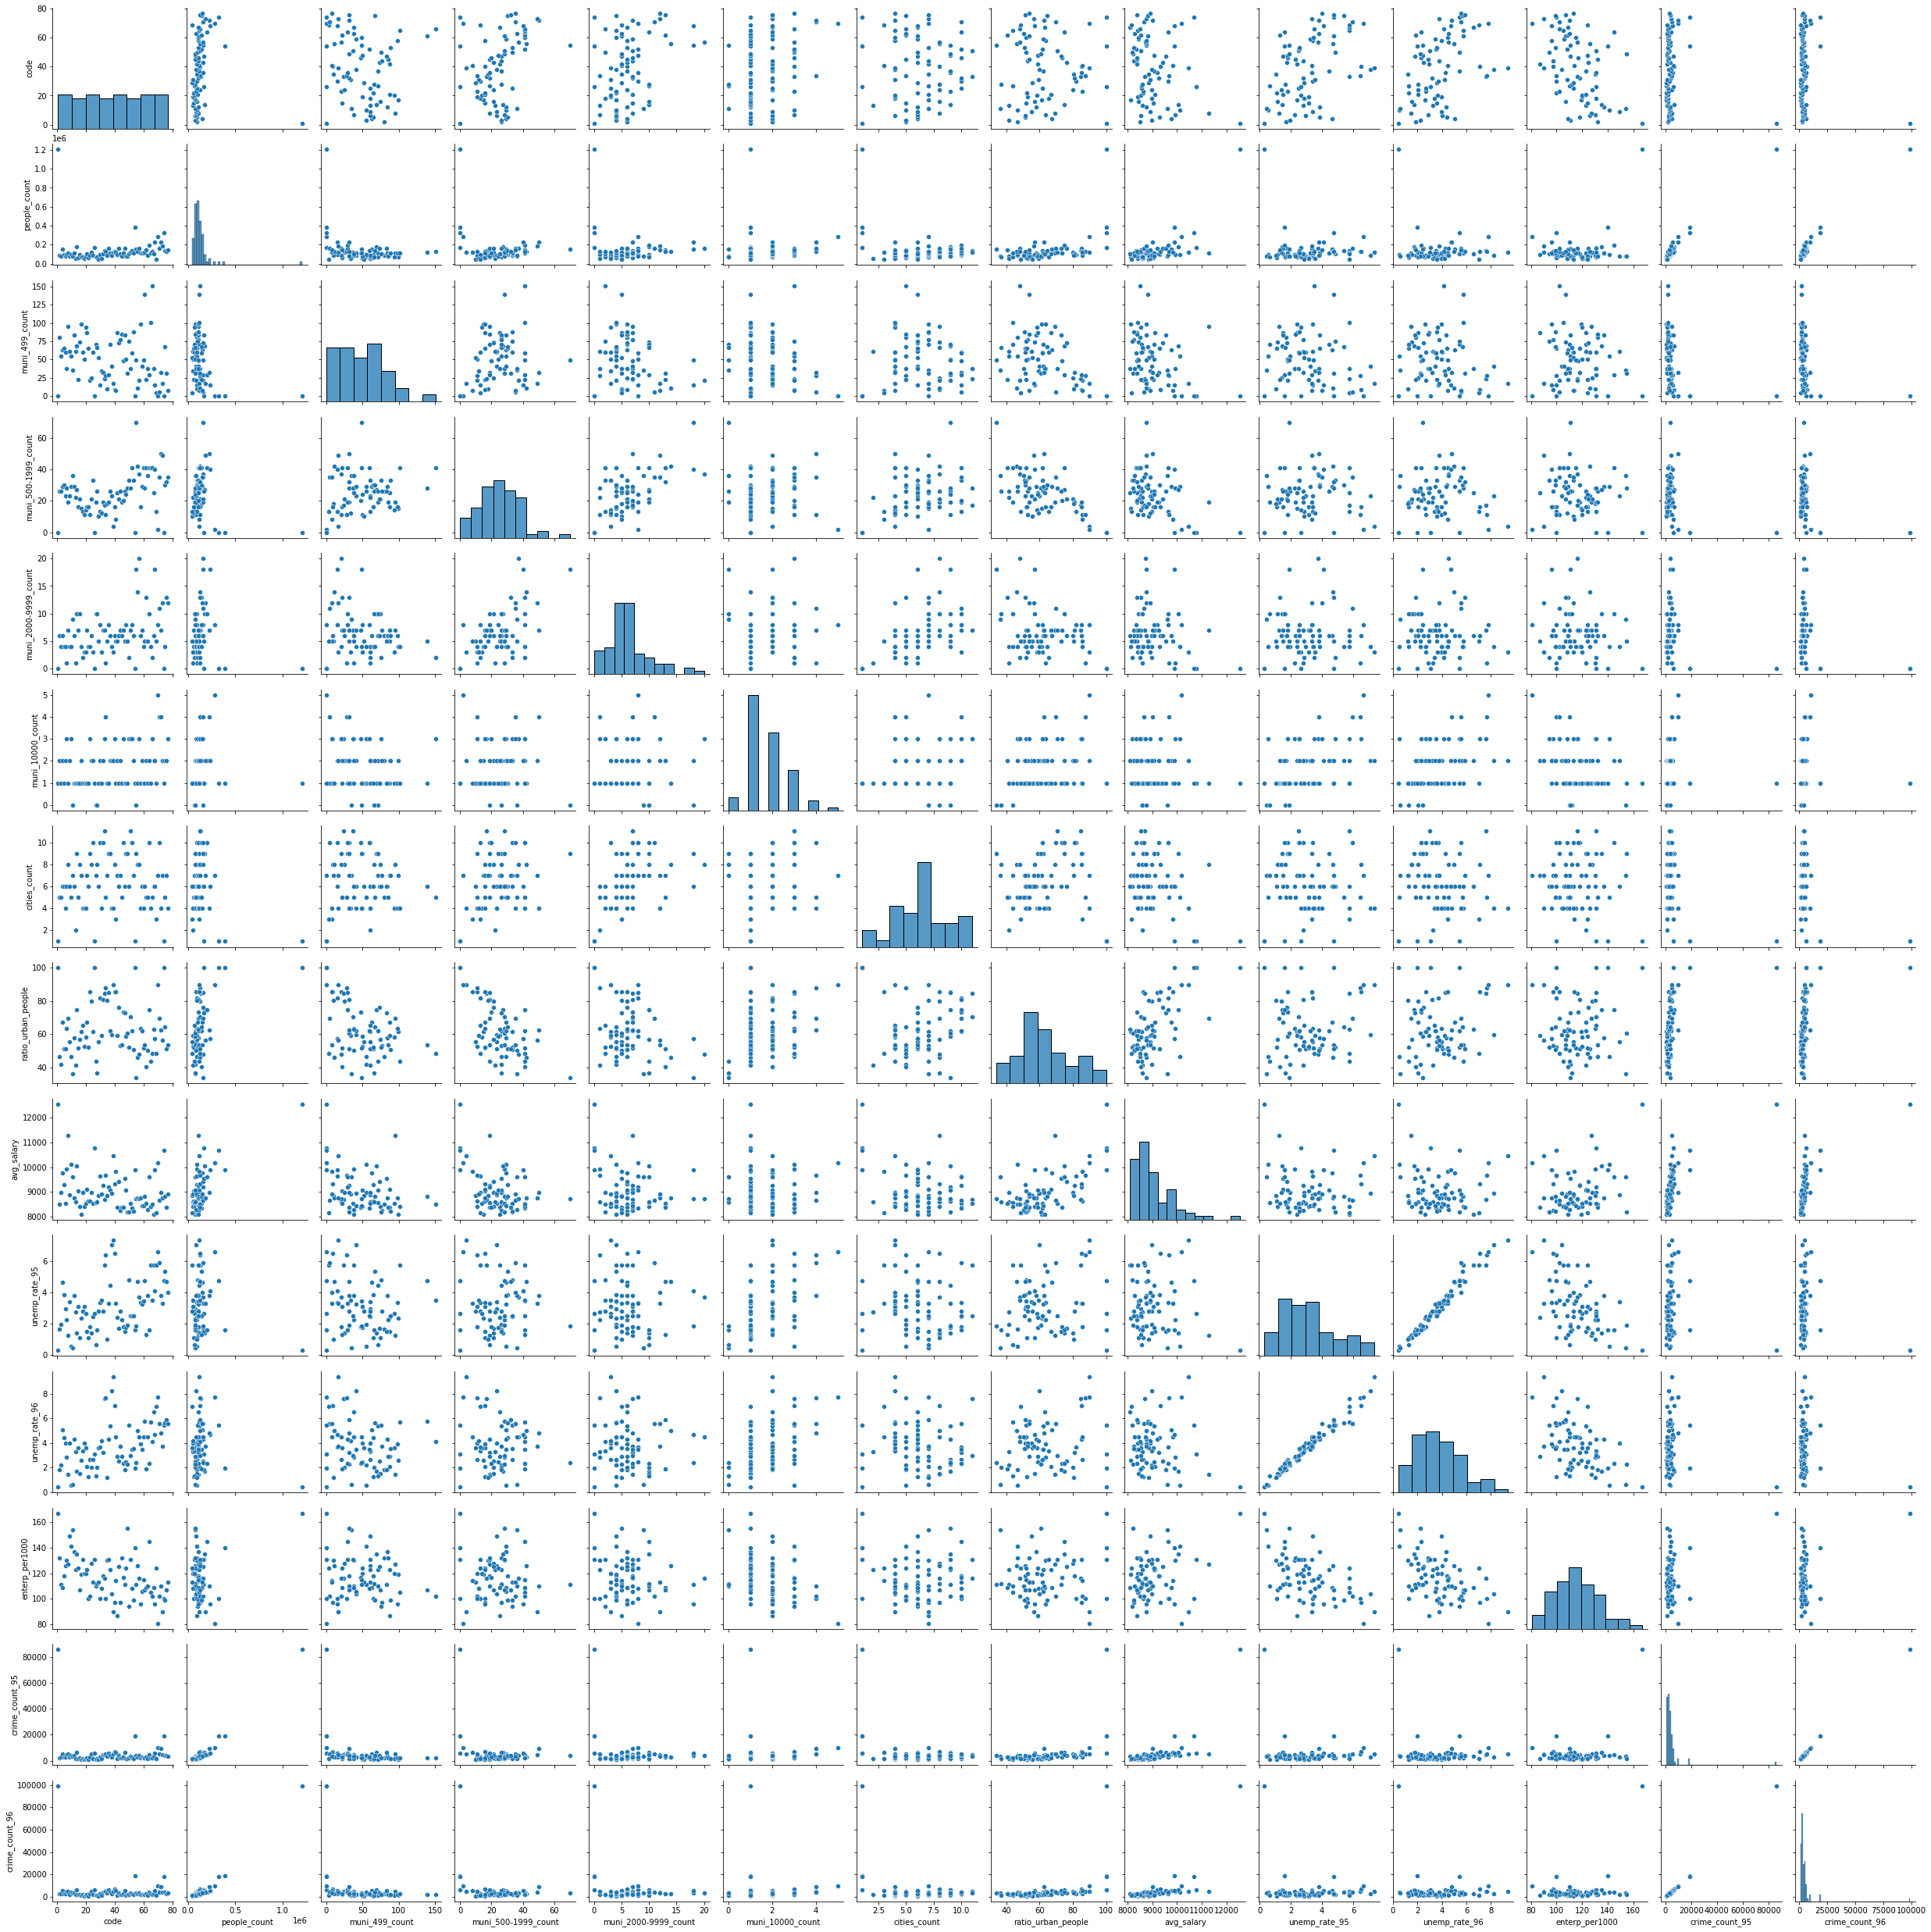

In [35]:
sb.pairplot(district_df)

#### Unemployment rate

<AxesSubplot:xlabel='unemp_rate_95', ylabel='unemp_rate_96'>

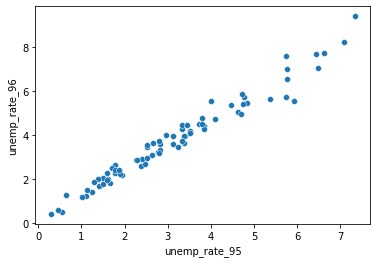

In [36]:
sb.scatterplot(x=district_df["unemp_rate_95"], y=district_df["unemp_rate_96"])

The relation between the unemployment rated in 1995 and 1996 in nearlly linear (with few outliers from the trend).

From these two, we could drop the most recent (1996), as it is less likely to affect the loan decisions. This is because the decisions on loans were taken considering only data relative to before the loan was conceded.

We decided that this 2 attributes could be joined into a single one, _unem_growth_, representing the growth of the unemployment rate.

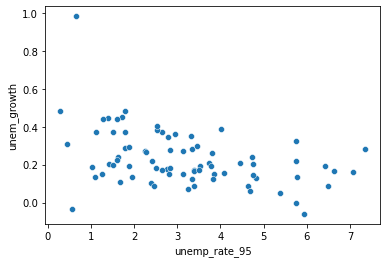

In [37]:
district_df["unem_growth"] = (district_df["unemp_rate_96"]/district_df["unemp_rate_95"]) - 1.0

sb.scatterplot(x=district_df["unemp_rate_95"], y=district_df["unem_growth"])
district_df.drop(["unemp_rate_95", "unemp_rate_96"], axis=1, inplace=True)

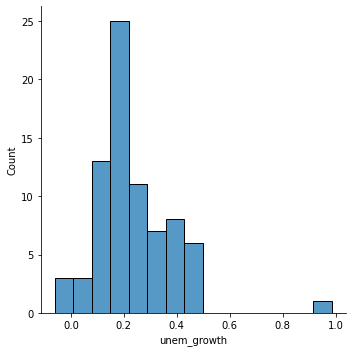

In [38]:
sb.displot(district_df["unem_growth"])

#### Crime count

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,crime_count_95,crime_count_96,unem_growth
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,167,85677.0,99107,0.482759
53,54,Brno - mesto,south Moravia,387570,0,0,0,1,1,100.0,9897,140,18721.0,18696,0.225000
69,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,81,9878.0,10108,0.168929
71,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,110,9672.0,9208,0.260526
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,100,18782.0,18347,0.145263


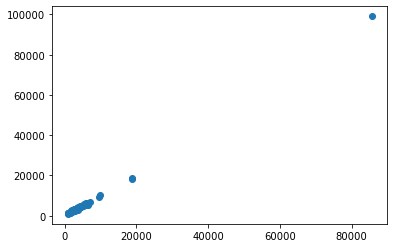

In [39]:
plt.scatter(district_df["crime_count_95"], district_df["crime_count_96"])

district_df[district_df["crime_count_95"] > 8000]

Although there is a big gap increase on the total number of crimes commited after 20000 crimes, from the plot, it can be concluded that there is a approximatelly linear correlation between the number of crimes commited in 1995 and 1996.

There are 3 regions with a much higher number of commited crimes: Prague, south Moravia, north Moravia. Even in the case of these regions, the relation is almost linear.

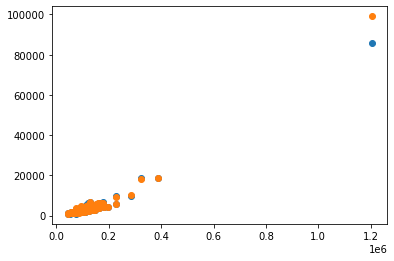

In [40]:
plt.scatter(district_df["people_count"], district_df["crime_count_95"])
plt.scatter(district_df["people_count"], district_df["crime_count_96"])

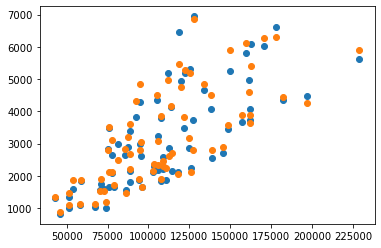

In [41]:
tmp = district_df[district_df["crime_count_95"] < 8000]
plt.scatter(tmp["people_count"], tmp["crime_count_95"])

tmp2 = district_df[district_df["crime_count_96"] < 8000]
plt.scatter(tmp2["people_count"], tmp2["crime_count_96"])

As expected, the higher the population, the more crimes are commited and this remains true for both years.

This means that it isn't a very useful information in this form. We can convert both crime counts to crime commited per 1000 habitants and use that to calculate the _crime growth_.

In [42]:
crime_per1000_95 = district_df["crime_count_95"] / (district_df["people_count"] / 1000)
crime_per1000_96 = district_df["crime_count_96"] / (district_df["people_count"] / 1000)

district_df["crime_growth"] = (crime_per1000_96/crime_per1000_95) - 1.0

district_df.drop(["crime_count_95", "crime_count_96"], axis=1, inplace=True)

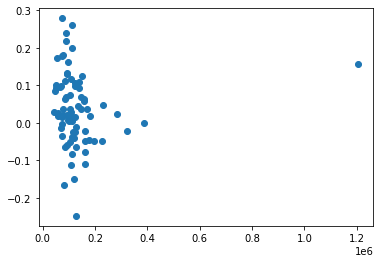

In [43]:
plt.scatter(district_df["people_count"], district_df["crime_growth"])

This new attribute, _crime\_growth_, isn't directly related to the population size.

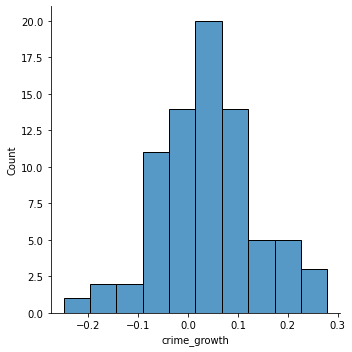

In [44]:
sb.displot(district_df["crime_growth"])

#### Skewness

Some attributes are heavily _skewed_. To take care of this, we apply `np.log` to the attribute.

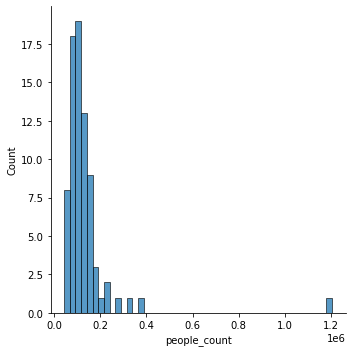

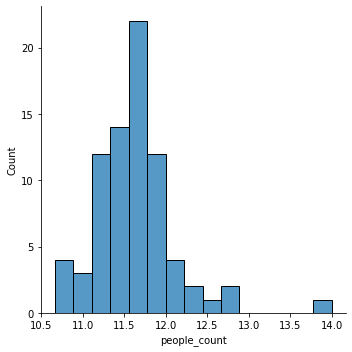

In [45]:
sb.displot(district_df["people_count"])

district_df["people_count"] = np.log(district_df["people_count"])
sb.displot(district_df["people_count"])

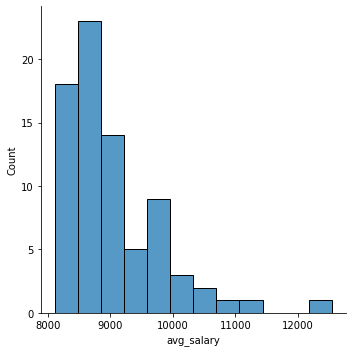

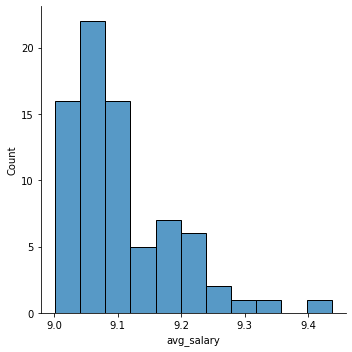

In [46]:
sb.displot(district_df["avg_salary"])

district_df["avg_salary"] = np.log(district_df["avg_salary"])
sb.displot(district_df["avg_salary"])

## Join data

It is needed to join all datasets into a **single one**.

In [47]:
def join(df1, df2, key1, key2, suff, t="inner"):
    return df1.merge(df2, left_on=key1, right_on=key2, how=t, suffixes=suff)

### Join account with disposition

All _Accounts_ have at least one _Disposition_. There are more _Dispositions_ than _Accounts_, because some clients are **owners** of an account while others are **disponent owners**.

In [48]:
disp_df["type"].value_counts()

OWNER        4500
DISPONENT     869
Name: type, dtype: int64

In order to join all data later, we will create an attribute on the _Account_ table that reflects whether the account is co-owned.

In [49]:
acc_disp = join(account_df, disp_df, "account_id", "account_id", ['', '_disp'])
acc_disp.rename(columns={"type": "account_type",
                         "date": "account_creation",
                         "frequency": "issuance_freq"}, inplace=True)
acc_disp

,account_id,district_id,issuance_freq,account_creation,disp_id,client_id,account_type
0,576,55,monthly issuance,930101,692,692,OWNER
1,576,55,monthly issuance,930101,693,693,DISPONENT
2,3818,74,monthly issuance,930101,4601,4601,OWNER
3,3818,74,monthly issuance,930101,4602,4602,DISPONENT
4,704,55,monthly issuance,930101,844,844,OWNER
...,...,...,...,...,...,...,...
5364,3958,59,monthly issuance,971228,4775,4775,DISPONENT
5365,777,30,monthly issuance,971228,929,929,OWNER
5366,1573,63,monthly issuance,971229,1906,1906,OWNER
5367,3276,1,monthly issuance,971229,3965,3965,OWNER


In [50]:
owner_count = acc_disp["account_id"].value_counts()
acc_disp["is_coowned"] = acc_disp.apply(lambda row: True if owner_count[row["account_id"]] > 1 else False, axis=1)

acc_disp[(acc_disp["account_type"] == "DISPONENT") & (acc_disp["is_coowned"] == True)]

,account_id,district_id,issuance_freq,account_creation,disp_id,client_id,account_type,is_coowned
1,576,55,monthly issuance,930101,693,693,DISPONENT,True
3,3818,74,monthly issuance,930101,4602,4602,DISPONENT,True
5,704,55,monthly issuance,930101,845,845,DISPONENT,True
11,793,47,monthly issuance,930103,951,951,DISPONENT,True
15,1726,48,monthly issuance,930103,2094,2094,DISPONENT,True
...,...,...,...,...,...,...,...,...
5339,2791,25,monthly issuance,971219,3371,3371,DISPONENT,True
5345,246,65,monthly issuance,971220,298,298,DISPONENT,True
5347,1171,18,monthly issuance,971220,1411,1411,DISPONENT,True
5364,3958,59,monthly issuance,971228,4775,4775,DISPONENT,True


Now the _DISPONENTs_ can be dropped from the joined table. The type attribute can also be dropped as all dispositions are _OWNER_.

In [51]:
acc_disp.drop(acc_disp[acc_disp["account_type"] == "DISPONENT"].index, inplace=True)
acc_disp.drop(["account_type"], axis=1, inplace=True)

df=acc_disp
df

,account_id,district_id,issuance_freq,account_creation,disp_id,client_id,is_coowned
0,576,55,monthly issuance,930101,692,692,True
2,3818,74,monthly issuance,930101,4601,4601,True
4,704,55,monthly issuance,930101,844,844,True
6,2378,16,monthly issuance,930101,2873,2873,False
7,2632,24,monthly issuance,930102,3177,3177,False
...,...,...,...,...,...,...,...
5362,124,55,monthly issuance,971228,149,149,False
5363,3958,59,monthly issuance,971228,4774,4774,True
5365,777,30,monthly issuance,971228,929,929,False
5366,1573,63,monthly issuance,971229,1906,1906,False


### Join clients

Nothing special needs to be done to join the _Client_ table. We can drop the some attributes (foreign keys).

In [52]:
df = join(df, client_df, 'client_id', 'client_id', ['', '_client'], t="left")
df.rename(columns={"age": "client_age"}, inplace=True)
df.drop(['client_id'], axis=1, inplace=True)
df

,account_id,district_id,issuance_freq,account_creation,disp_id,is_coowned,district_id_client,is_male,client_age
0,576,55,monthly issuance,930101,692,True,74,False,50-65
1,3818,74,monthly issuance,930101,4601,True,1,True,50-65
2,704,55,monthly issuance,930101,844,True,22,True,50-65
3,2378,16,monthly issuance,930101,2873,False,16,False,20-29
4,2632,24,monthly issuance,930102,3177,False,24,True,50-65
...,...,...,...,...,...,...,...,...,...
4495,124,55,monthly issuance,971228,149,False,55,True,50-65
4496,3958,59,monthly issuance,971228,4774,True,59,True,40-49
4497,777,30,monthly issuance,971228,929,False,30,True,50-65
4498,1573,63,monthly issuance,971229,1906,False,63,True,retired


### Join district

Both the _Account_ and the _Client_ table have a foreign key to the _District_ table.

Only the _Client_ key will be joined with the _District_ table, because we only care about the account owner's residence and now the place where the account was registered.

In [53]:
df = join(df, district_df, 'district_id_client', 'code', ['', '_district'])
df.rename(columns={"code": "district_code", "name": "district_name"}, inplace=True)
df.drop(['district_id', 'district_id_client'], axis=1, inplace=True)
df

,account_id,issuance_freq,account_creation,disp_id,is_coowned,is_male,client_age,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,unem_growth,crime_growth
0,576,monthly issuance,930101,692,True,False,50-65,74,Ostrava - mesto,north Moravia,12.688097,0,0,0,1,1,100.0,9.275472,100,0.145263,-0.023160
1,2484,monthly issuance,930103,2999,False,False,0-19,74,Ostrava - mesto,north Moravia,12.688097,0,0,0,1,1,100.0,9.275472,100,0.145263,-0.023160
2,1338,monthly issuance,930111,1619,True,False,50-65,74,Ostrava - mesto,north Moravia,12.688097,0,0,0,1,1,100.0,9.275472,100,0.145263,-0.023160
3,1179,monthly issuance,930123,1419,True,False,retired,74,Ostrava - mesto,north Moravia,12.688097,0,0,0,1,1,100.0,9.275472,100,0.145263,-0.023160
4,1649,monthly issuance,930126,1999,False,False,0-19,74,Ostrava - mesto,north Moravia,12.688097,0,0,0,1,1,100.0,9.275472,100,0.145263,-0.023160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1976,monthly issuance,970325,2401,False,False,50-65,26,Plzen - mesto,west Bohemia,12.046191,0,0,0,1,1,100.0,9.286097,131,0.170455,0.036418
4496,3176,monthly issuance,970326,3841,False,True,retired,26,Plzen - mesto,west Bohemia,12.046191,0,0,0,1,1,100.0,9.286097,131,0.170455,0.036418
4497,768,monthly issuance,970703,918,False,True,30-39,26,Plzen - mesto,west Bohemia,12.046191,0,0,0,1,1,100.0,9.286097,131,0.170455,0.036418
4498,307,monthly issuance,970807,374,False,True,30-39,26,Plzen - mesto,west Bohemia,12.046191,0,0,0,1,1,100.0,9.286097,131,0.170455,0.036418


### Join transactions

// TODO

### Join loan

In [54]:
df = join(df, loan_df, 'account_id', 'account_id', ['', '_loan'], t="right")
df.drop(['account_id', 'loan_id'], axis=1, inplace=True)
df

,issuance_freq,account_creation,disp_id,is_coowned,is_male,client_age,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,unem_growth,crime_growth,date,amount,duration,payments,status,year_loan,month_loan
0,weekly issuance,930322,2166,False,False,50-65,30,Sokolov,west Bohemia,11.459651,15,13,8,2,10,81.8,9.174713,100,0.085799,-0.060637,930705,96396,12,8033,-1,93,7
1,monthly issuance,930213,2181,False,True,30-39,46,Nachod,east Bohemia,11.632565,48,20,7,3,10,73.5,9.032290,117,0.290503,-0.082691,930711,165960,36,4610,1,93,7
2,monthly issuance,930208,11006,False,True,50-65,45,Jicin,east Bohemia,11.263399,85,19,6,1,5,53.5,9.034796,132,0.267544,0.020192,930728,127080,60,2118,1,93,7
3,monthly issuance,930130,2235,False,False,50-65,14,Ceske Budejovice,south Bohemia,12.087773,69,27,10,1,9,74.8,9.214830,135,0.204225,-0.046790,930803,105804,36,2939,1,93,8
4,weekly issuance,930214,13231,False,True,20-29,63,Vyskov,south Moravia,11.368050,38,36,5,1,5,50.5,9.022564,110,0.192612,-0.065301,930906,274740,60,4579,1,93,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,monthly issuance,950121,10813,True,False,20-29,72,Olomouc,north Moravia,12.328830,32,50,7,4,4,62.6,9.104313,110,0.260526,-0.047974,961212,155616,48,3242,1,96,12
324,monthly issuance,951129,3855,False,True,50-65,29,Rokycany,west Bohemia,10.730160,52,10,5,1,6,55.6,9.087381,113,0.276596,0.085575,961215,222180,60,3703,-1,96,12
325,monthly issuance,960521,10742,False,False,40-49,70,Karvina,north Moravia,12.561601,0,2,8,5,7,89.9,9.227886,81,0.168929,0.023284,961221,45024,48,938,1,96,12
326,monthly issuance,950520,13172,False,True,40-49,16,Jindrichuv Hradec,south Bohemia,11.450316,74,21,10,1,8,56.9,9.039196,107,0.375000,0.020811,961225,115812,36,3217,1,96,12


### Join card

In [55]:
df[df.account_creation == 930226]

,issuance_freq,account_creation,disp_id,is_coowned,is_male,client_age,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,unem_growth,crime_growth,date,amount,duration,payments,status,year_loan,month_loan
20,monthly issuance,930226,2,True,True,50-65,1,Hl.m. Praha,Prague,14.001951,0,0,0,1,1,100.0,9.436759,167,0.482759,0.156752,940105,80952,24,3373,1,94,1
21,monthly issuance,930226,8865,True,True,50-65,1,Hl.m. Praha,Prague,14.001951,0,0,0,1,1,100.0,9.436759,167,0.482759,0.156752,940105,80952,24,3373,1,94,1


In [56]:
account_df[account_df.date == 930226]

,account_id,district_id,frequency,date
181,496,69,monthly issuance,930226
182,2,1,monthly issuance,930226
183,7401,1,monthly issuance,930226


// TODO

In [57]:
df.drop(['disp_id'], axis=1, inplace=True)

### Look for duplicated rows

// TODO
there are dups becase we dropped the disp_id above without joining the actual card table.

In [58]:
df.drop(df.drop_duplicates().index)

,issuance_freq,account_creation,is_coowned,is_male,client_age,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,unem_growth,crime_growth,date,amount,duration,payments,status,year_loan,month_loan
21,monthly issuance,930226,True,True,50-65,1,Hl.m. Praha,Prague,14.001951,0,0,0,1,1,100.0,9.436759,167,0.482759,0.156752,940105,80952,24,3373,1,94,1
239,monthly issuance,950407,False,False,50-65,21,Tabor,south Bohemia,11.545848,87,16,7,1,7,67.0,9.116469,123,0.370861,0.023923,960429,30276,12,2523,-1,96,4
267,monthly issuance,951109,True,False,20-29,60,Prostejov,south Moravia,11.614064,49,41,4,1,4,51.9,9.040856,115,0.298551,0.198510,960802,89340,60,1489,1,96,8
304,monthly issuance,960306,False,False,50-65,70,Karvina,north Moravia,12.561601,0,2,8,5,7,89.9,9.227886,81,0.168929,0.023284,961029,86184,12,7182,1,96,10


### Save joined data

In [59]:
train_data_join='cool_data/train-data-join.csv'
df.to_csv(train_data_join, index=False)

## Deal with categorical data

In [60]:
df.dtypes

issuance_freq             object
account_creation           int64
is_coowned                  bool
is_male                     bool
client_age              category
district_code              int64
district_name             object
region                    object
people_count             float64
muni_499_count             int64
muni_500-1999_count        int64
muni_2000-9999_count       int64
muni_10000_count           int64
cities_count               int64
ratio_urban_people       float64
avg_salary               float64
enterp_per1000             int64
unem_growth              float64
crime_growth             float64
date                       int64
amount                     int64
duration                   int64
payments                   int64
status                     int64
year_loan                  int64
month_loan                 int64
dtype: object

### Issuance frequency

The frequency is categorical data. Let's look at the cardinality of the attribute and whether it has an implicit order.

In [61]:
df['issuance_freq'].value_counts()

monthly issuance              259
weekly issuance                51
issuance after transaction     18
Name: issuance_freq, dtype: int64

There are 3  possible values for the **frquency attribute**: _monthly issuance_, _weekly issuance_, _issuance_ after transation. There is an implicit order between weekly and monthly, but with _issuance after transation_ it isn't so obvious. It was decided that, since it is expected that people do more than 1 transaction per week, _issuance after transation_ also relates to the other 2 in terms of time.

When considering the time intervals between transations: _issuance after transation_ < _weekly issuance_ < _monthly issuance_.

There is also a magnitude difference between all of them, e.g.: monthly is around 4 times more frequent than weekly. This raises the issue of how much more frequent is _issuance after transaction_ than _weekly issuance_. Let's assume the _weekly issuance_ is 7 time less frequent.

Let's replace this categorical data by ordered integers:

In [62]:
df.replace({'issuance_freq':
                {'issuance after transaction': 1,
                 'weekly issuance': 7,
                 'monthly issuance': 30}
            }, inplace=True)
df['issuance_freq']

0       7
1      30
2      30
3      30
4       7
       ..
323    30
324    30
325    30
326    30
327    30
Name: issuance_freq, Length: 328, dtype: int64

### Client age

_client_age_ is a categorical value. Each category represents a range. This ranges can be divided into 2 attributes: the start and the end of the range.

In [63]:
def uncat_age_bins(row, is_begin=True):
    age = row['client_age']
    if age == 'retired':
        return 66 if is_begin else 150
    return age.split('-')[0 if is_begin else 1]
    

df['age_start'] = df.apply(uncat_age_bins, axis=1)
df['age_end'] = df.apply(lambda x: uncat_age_bins(x, False), axis=1)

df.drop(['client_age'], axis=1, inplace=True)

df.head()

,issuance_freq,account_creation,is_coowned,is_male,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,unem_growth,crime_growth,date,amount,duration,payments,status,year_loan,month_loan,age_start,age_end
0,7,930322,False,False,30,Sokolov,west Bohemia,11.459651,15,13,8,2,10,81.8,9.174713,100,0.085799,-0.060637,930705,96396,12,8033,-1,93,7,50,65
1,30,930213,False,True,46,Nachod,east Bohemia,11.632565,48,20,7,3,10,73.5,9.032290,117,0.290503,-0.082691,930711,165960,36,4610,1,93,7,30,39
2,30,930208,False,True,45,Jicin,east Bohemia,11.263399,85,19,6,1,5,53.5,9.034796,132,0.267544,0.020192,930728,127080,60,2118,1,93,7,50,65
3,30,930130,False,False,14,Ceske Budejovice,south Bohemia,12.087773,69,27,10,1,9,74.8,9.214830,135,0.204225,-0.046790,930803,105804,36,2939,1,93,8,50,65
4,7,930214,False,True,63,Vyskov,south Moravia,11.368050,38,36,5,1,5,50.5,9.022564,110,0.192612,-0.065301,930906,274740,60,4579,1,93,9,20,29


### District data

Both name and region are categorical data relating to regions.

In [64]:
print("Number of different 'code' values:", len(df['district_code'].value_counts()))
print("Number of different 'name' values:", len(df['district_name'].value_counts()))

Number of different 'code' values: 73
Number of different 'name' values: 73


We can see that there is a direct association between the **code** and **name** attributes. This means they are redundant and we don't have to deal with the **name** attribute.

There is a problem with this. The **code** attributes are integers which indirectly imply an order, even though the names of the regions are nominal features, but it encoding it would generate too many attributes, so it was decided that it would be dropped.

In [65]:
df.drop(['district_name'], axis=1, inplace=True)

The **region** feature is categorial and there is no order associated. This means this attribute should be encoded in order to remove it's categorical nature and still remain unordered. One-Hot encoding could be used for simplicity, but Binary enconding is be better.

In [66]:
df['region'].value_counts()

south Moravia      68
north Moravia      51
Prague             41
east Bohemia       40
central Bohemia    37
south Bohemia      31
west Bohemia       30
north Bohemia      30
Name: region, dtype: int64

In [67]:
from category_encoders import BinaryEncoder

encoder = BinaryEncoder(cols=['region'])
df = encoder.fit_transform(df)
df.head()

,issuance_freq,account_creation,is_coowned,is_male,district_code,region_0,region_1,region_2,region_3,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,enterp_per1000,unem_growth,crime_growth,date,amount,duration,payments,status,year_loan,month_loan,age_start,age_end
0,7,930322,False,False,30,0,0,0,1,11.459651,15,13,8,2,10,81.8,9.174713,100,0.085799,-0.060637,930705,96396,12,8033,-1,93,7,50,65
1,30,930213,False,True,46,0,0,1,0,11.632565,48,20,7,3,10,73.5,9.032290,117,0.290503,-0.082691,930711,165960,36,4610,1,93,7,30,39
2,30,930208,False,True,45,0,0,1,0,11.263399,85,19,6,1,5,53.5,9.034796,132,0.267544,0.020192,930728,127080,60,2118,1,93,7,50,65
3,30,930130,False,False,14,0,0,1,1,12.087773,69,27,10,1,9,74.8,9.214830,135,0.204225,-0.046790,930803,105804,36,2939,1,93,8,50,65
4,7,930214,False,True,63,0,1,0,0,11.368050,38,36,5,1,5,50.5,9.022564,110,0.192612,-0.065301,930906,274740,60,4579,1,93,9,20,29


### Card data

// TODO

The **type** attribute is probably categorical data.

In [68]:
#df['type'].value_counts()

_junior_ accounts are for underarge people (lowest tier) and usually it isn't possible to withdrawl money from them, and _gold_ account are the highest tier. There is an implicit order here: _junior_ < _classic_ < _gold_.

In [69]:
#df.replace({'type':
#                    {'junior': 0, 'classic': 1, 'gold': 2}
#                   }, inplace=True)
#df['type']

### Transaction data

There are also 4 categorical attributes in this dataframe: _type_, _operation_, _k\_symbol_, and _bank_.

In [70]:
#trans_df['type'].value_counts()

The _type_ attribute has 3 categories with no distinct order between them.

In [71]:
#from category_encoders import BinaryEncoder

#encoder = BinaryEncoder(cols=['type'])
#trans_df = encoder.fit_transform(trans_df)
#trans_df.head()

This data could have been encoded with One-Hot encoding, which is simpler. Binary encoding is used in order to use 1 less attribute.

In [72]:
#trans_df.drop(['operation', 'k_symbol', 'bank'], axis=1, inplace=True)

## Classification

In [73]:
def getXy(df):
    # inputs
    X = df.drop(["status"], axis=1)
    # target
    y = df["status"]
    return (X, y)

X_train, y_train = getXy(df)
# // TODO scale data?

Note that we scaled our data. We did this because we need it to obtain better results on distance-based models: K-NN and SVC. This doesn't affect tree-based algorithms so we do it here.

In [74]:
from sklearn.model_selection import StratifiedKFold

k = 10
kf = StratifiedKFold(n_splits=k)

We will be using **Stratified K-Fold with 10 folds** for our cross-validations.

### Establishing a baseline

Let's establish a baseline for our classifiers.

In [75]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

baseline_clfs = [
    {"name": "Decision tree", "clf": DecisionTreeClassifier()},
    #{"name": "K-Nearest neighbors", "clf": KNeighborsClassifier()},
    {"name": "Naive Bayes", "clf": GaussianNB()},
]

scoring = {"accuracy": "accuracy",
           "precision": "precision_weighted",
           "recall": "recall_weighted",
           "f1": "f1_weighted"}

# save classifier information in DataFrame: name, score, fit_time, score_time
baseline_df = pd.DataFrame()
for clf_entry in baseline_clfs:
    scores = cross_validate(clf_entry["clf"], X_train, y_train, scoring=scoring, cv=kf, n_jobs=configNJobs)
    info = scores | {"classifier": [clf_entry["name"]] * k}
    baseline_df = baseline_df.append(pd.DataFrame(info))

baseline_df

/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,classifier
0,0.005799,0.003412,0.484848,0.760606,0.484848,0.552563,Decision tree
1,0.004641,0.012319,0.666667,0.768116,0.666667,0.705882,Decision tree
2,0.007833,0.004799,0.787879,0.711632,0.787879,0.747817,Decision tree
3,0.004213,0.003257,0.818182,0.880471,0.818182,0.837163,Decision tree
4,0.006262,0.003150,0.757576,0.707071,0.757576,0.731452,Decision tree
5,0.003485,0.003127,0.727273,0.748036,0.727273,0.737190,Decision tree
6,0.014461,0.003575,0.666667,0.820937,0.666667,0.721569,Decision tree
7,0.007354,0.003341,0.606061,0.854209,0.606061,0.673996,Decision tree
8,0.011497,0.005104,0.750000,0.750000,0.750000,0.750000,Decision tree
9,0.006667,0.002972,0.812500,0.812500,0.812500,0.812500,Decision tree
